# PyTorch Computer Vision Tutorial


This notebook covers:
- Loading and visualizing the MNIST dataset
- Training a simple Multi-Layer Perceptron (MLP)
- Training a Convolutional Neural Network (CNN)
- A mini data-challenge on FashionMNIST

## 1. Loading MNIST Dataset

### MNIST Dataset  

The **MNIST (Modified National Institute of Standards and Technology)** dataset is a collection of **70,000 grayscale images** of handwritten digits from **0 to 9**, commonly used for training and benchmarking machine learning models in image classification.  

#### Key Features:  
- **60,000 training images** and **10,000 test images**  
- Each image is **28×28 pixels** in size  
- Pixel values range from **0 (black) to 255 (white)**  
- Labels correspond to the digit (0–9) present in the image 


### To get access to GPUs: [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/rmenegaux/Intro-to-Neural-Nets-AIMS-2025/blob/main/practical2_CNN.ipynb)


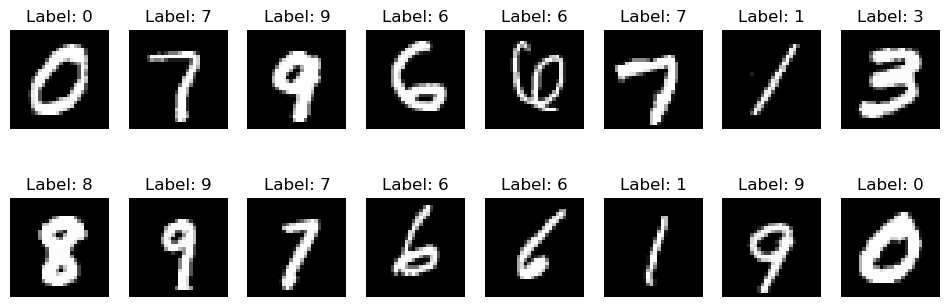

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Define a transform to normalize the dataset and convert it to tensors
transform = transforms.Compose([transforms.ToTensor()])

# Load the MNIST training dataset
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Create a DataLoader for easy batch processing
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)

# Load the test dataset
test_dataset = torchvision.datasets.MNIST(root="./data", train=False, transform=transform, download=True)

# Get a batch of images and labels
images, labels = next(iter(train_loader))

# Plot some sample images
fig, axes = plt.subplots(2, 8, figsize=(12, 4))
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i].squeeze(), cmap='gray')
    ax.set_title(f'Label: {labels[i].item()}')
    ax.axis('off')

plt.show()

### Manipulating data in PyTorch  

In the code above, we used a `DataLoader` to load batches of images from the MNIST dataset efficiently.
```python
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
```

A [`DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) is a PyTorch utility that helps **manage large datasets** by handling:  
- **Batching**: Instead of loading one sample at a time, it loads multiple samples together, improving training efficiency.  
- **Shuffling**: It randomly shuffles the dataset at each epoch, helping the model generalize better.  
- **Parallel Loading**: It allows multiple workers to load data in parallel, speeding up training.

In the example above, one _iteration_ from the dataloader returns a batch of 16 images and their labels

I.1. First try with an MLP
---

As a baseline model, we first implement a fully-connected network.
### **1. Define the MLP Network**  
1. **Define the Model**  
   - We flatten the **28×28** images into **1D vectors**.  
   - The network has **two hidden layers** with **ReLU activations**.  
   - The final layer outputs **logits for 10 classes**. 

In [ ]:
import torch.nn as nn

# Define the MLP model
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        # TODO: fill in the dimensions of the linear layers, and the flattening
        self.fc1 = nn.Linear(...)  # First hidden layer
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(...)  # Second hidden layer
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(...)  # Output layer

    def forward(self, x):
        x = ...  # Flatten 28x28 images into vectors
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.fc3(x)  # No activation (logits output)
        return x
    
# Initialize model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mlp_model = MLP().to(device)

print(mlp_model)

### 2. Training the network
- 2.a. Define the training **optimizer** and the **loss function**

- 2.b. Implement the **training loop**
   - Each batch goes through a **forward pass**.  
   - We compute the **Cross-Entropy Loss**.  
   - Use **backpropagation** to compute gradients.  
   - Update model parameters using **Adam optimizer**.

In [ ]:
# Load MNIST dataset

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)

# TODO: Define the loss function and the optimizer
criterion = ...  # Loss function for classification
optimizer = ...

# Training loop
num_epochs = 5
def train(model, optimizer, train_loader, num_epochs=1):
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0

        for images, labels in train_loader:
            # Transfer data to model device (if it is on GPU)
            images, labels = images.to(device), labels.to(device)

            # TODO: Perform the forward pass, backward pass and parameter updates
            # Forward pass
            loss = criterion(...)

            # Backpropagation
            optimizer.zero_grad()  # Reset gradients
            ...  # Compute gradients
            ...  # Update weights

            running_loss += loss.item()

        print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}")

train(mlp_model, optimizer, num_epochs, train_loader)


Epoch 1, Loss: 0.2434
Epoch 2, Loss: 0.1006
Epoch 3, Loss: 0.0708
Epoch 4, Loss: 0.0553
Epoch 5, Loss: 0.0438



### **3. Evaluation and Error Analysis**  
   - Compute **classification accuracy**.  
   - Identify misclassified images.  
   - **Plot 10 misclassified digits** with true & predicted labels. 

Test Accuracy: 0.97%

Classification Report:

              precision    recall  f1-score   support

           0     0.9818    0.9929    0.9873       980
           1     0.9903    0.9912    0.9908      1135
           2     0.9812    0.9583    0.9696      1032
           3     0.9701    0.9653    0.9677      1010
           4     0.9725    0.9725    0.9725       982
           5     0.9952    0.9350    0.9642       892
           6     0.9782    0.9843    0.9813       958
           7     0.9505    0.9893    0.9695      1028
           8     0.9425    0.9764    0.9592       974
           9     0.9669    0.9554    0.9611      1009

    accuracy                         0.9726     10000
   macro avg     0.9729    0.9721    0.9723     10000
weighted avg     0.9729    0.9726    0.9726     10000



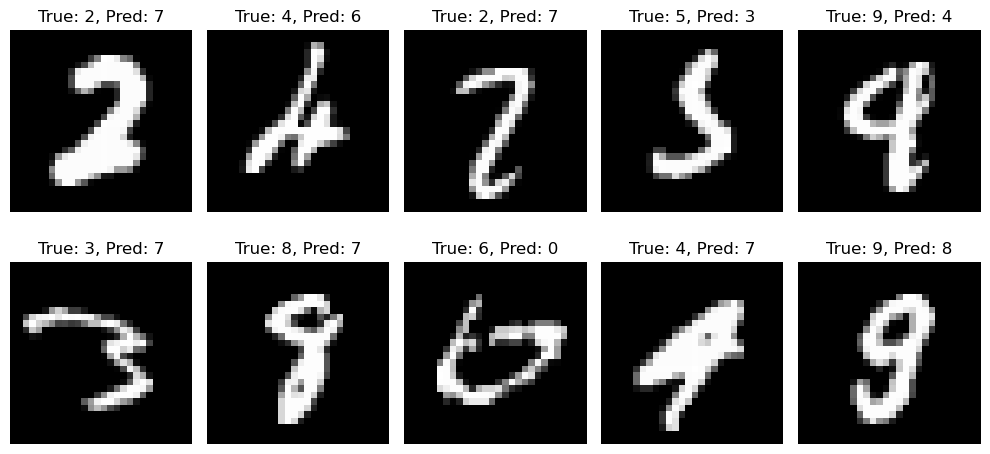

In [ ]:
from sklearn.metrics import classification_report, accuracy_score

def evaluate(model, test_loader):
    # Set model to evaluation mode
    model.eval()

    y_true = []
    y_pred = []

    with torch.no_grad():  # No gradient computation needed for inference
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            # TODO: Compute model outputs, and convert them to predicted classes
            outputs = ...
            predicted = ... # Predicted class, in {0, 1, ..., 9}

            # Store true and predicted labels
            y_true.extend(labels.cpu().numpy())  
            y_pred.extend(predicted.cpu().numpy())

    # Compute accuracy
    print(f"Test Accuracy: {accuracy_score(y_true, y_pred):.2f}%")

    # Print classification report
    print("\nClassification Report:\n")
    print(classification_report(y_true, y_pred, digits=3))

evaluate(mlp_model, test_loader)

### **Next Step: Convolutional Neural Networks (CNNs)**
Now that we've built an MLP, the next step is improving performance with a **CNN**, which can better capture spatial patterns in images! 🚀

#### **What’s Different from MLP?**
1. **Convolutional layers** (`Conv2d`) extract spatial features.
2. **Pooling** (`MaxPool2d`) reduces spatial dimensions.
3. **Fewer parameters** than a fully connected MLP while being more powerful.
4. **Better generalization** due to weight sharing in convolutional layers.

You can reuse the **training** and **evaluation** code as-is!

In [ ]:
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        # TODO: Choose the hyperparameters of the convolutional layers
        self.conv1 = nn.Conv2d(in_channels=..., out_channels=..., kernel_size=..., padding=...)
        self.conv2 = nn.Conv2d(in_channels=..., out_channels=..., kernel_size=..., padding=...)
        self.pool = nn.MaxPool2d(kernel_size=..., stride=...)  # 2x2 max pooling

        # TODO: Same for the Fully connected layers
        self.fc1 = nn.Linear(..., 128)  # what size is the input to FC1 ?
        self.fc2 = nn.Linear(128, ...)  # what size does the output have to be?

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # Conv1 -> ReLU -> MaxPool
        x = self.pool(F.relu(self.conv2(x)))  # Conv2 -> ReLU -> MaxPool
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))  # Fully connected layer with ReLU
        x = self.fc2(x)  # Output logits
        return x

# Instantiate model
cnn_model = CNN().to(device)
# Print model architecture
print(cnn_model)

In [ ]:
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=0.001)

# Training loop
num_epochs = 5
train(cnn_model, optimizer, num_epochs, train_loader)

Epoch 1, Loss: 0.1236
Epoch 2, Loss: 0.0421
Epoch 3, Loss: 0.0283
Epoch 4, Loss: 0.0192
Epoch 5, Loss: 0.0145


Test Accuracy: 0.99%

Classification Report:

              precision    recall  f1-score   support

           0     0.9889    0.9969    0.9929       980
           1     0.9947    0.9974    0.9960      1135
           2     0.9893    0.9893    0.9893      1032
           3     0.9308    0.9990    0.9637      1010
           4     0.9919    0.9929    0.9924       982
           5     0.9909    0.9720    0.9813       892
           6     0.9895    0.9864    0.9880       958
           7     0.9980    0.9805    0.9892      1028
           8     0.9957    0.9528    0.9738       974
           9     0.9890    0.9832    0.9861      1009

    accuracy                         0.9854     10000
   macro avg     0.9859    0.9850    0.9853     10000
weighted avg     0.9859    0.9854    0.9855     10000



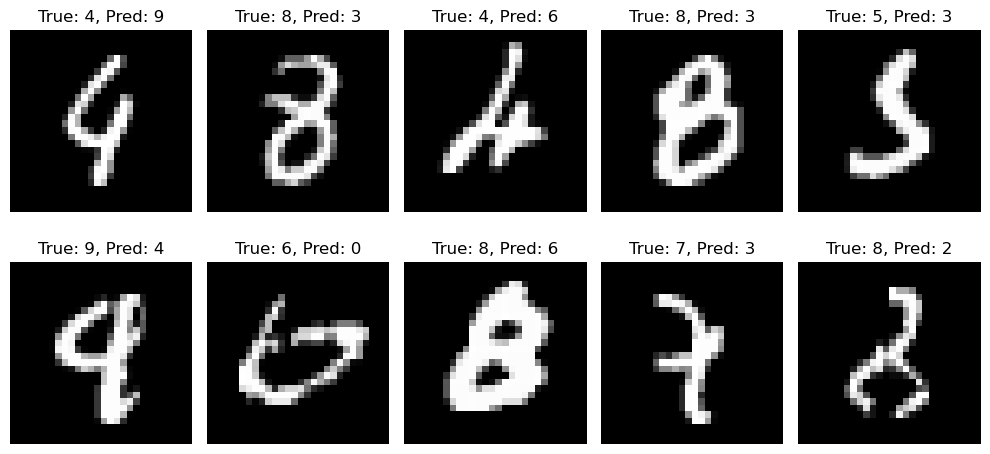

In [ ]:
evaluate(cnn_model, test_loader)

### **Simple Image Classification Challenge**  

Try to get the best performance as possible on **Fashion-MNIST**, a dataset similar to MNIST but with images of clothing items instead of digits.  

#### **Challenge: Classify Clothing Items from Fashion-MNIST**  

**Dataset:**  
- Fashion-MNIST contains **70,000 grayscale images** (60,000 train + 10,000 test).  
- Each image is **28×28 pixels**, like MNIST.  
- 10 classes:  
  1. T-shirt/top  
  2. Trouser  
  3. Pullover  
  4. Dress  
  5. Coat  
  6. Sandal  
  7. Shirt  
  8. Sneaker  
  9. Bag  
  10. Ankle boot  

---

#### **Tasks for Students**  

1. **Load Fashion-MNIST** using `torchvision.datasets.FashionMNIST`.  
2. **Baseline**: get a first baseline classification performance, with the previous MLP or CNN
3. **Challenge**: Modify the model to improve accuracy.  
   - Change the hyper-parameters 
   - Apply **data augmentation** (e.g., random flips, rotations).  

Fashion-MNIST is slightly more challenging than MNIST because the images contain more complex patterns and textures. However, it is still relatively saturated —- MLPs can achieve ~89% accuracy, and CNNs can reach ~93-95%.

26422272it [00:05, 4773660.37it/s]                              


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



29696it [00:00, 145627.18it/s]                          


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



4422656it [00:10, 416822.35it/s]                              


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



6144it [00:00, 2318262.30it/s]          


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



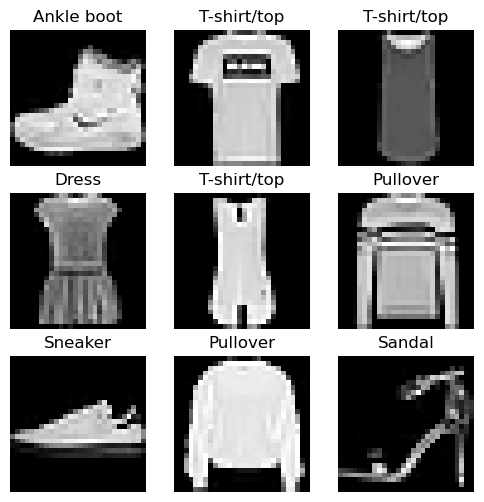

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Define transformation
transform = transforms.Compose([transforms.ToTensor()])

# Load dataset
train_dataset = torchvision.datasets.FashionMNIST(root="./data", train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root="./data", train=False, download=True, transform=transform)

# TODO: Define train and test DataLoader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=..., shuffle=...)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=..., shuffle=...)

# Class labels
class_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

# Visualize some sample images
def show_images(dataset, num_images=9):
    fig, axes = plt.subplots(3, 3, figsize=(6, 6))
    for i, ax in enumerate(axes.flat):
        image, label = dataset[i]
        ax.imshow(image.squeeze(), cmap="gray")
        ax.set_title(class_names[label])
        ax.axis("off")
    plt.show()

show_images(train_dataset)


In [ ]:
# TODO: Instantiate model of your choice
model = ...
model = model.to(device)
# Print model architecture
print(model)
# TODO: Choose an optimizer
optimizer = ...

# Training loop
num_epochs = ...
train(model, optimizer, num_epochs, train_loader)
evaluate(model, test_loader)